# STEP 1: 시계열 데이터 준비

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
# Date 컬럼을 인덱스로 지정.
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


Open    High     Low   Close  Adj Close      Volume
Date                                                             
2000-01-04  6000.0  6110.0  5660.0  6110.0   0.090599  74195000.0
2000-01-05  5800.0  6060.0  5520.0  5580.0   0.082740  74680000.0
2000-01-06  5750.0  5780.0  5580.0  5620.0   0.083333  54390000.0
2000-01-07  5560.0  5670.0  5360.0  5540.0   0.082147  40305000.0
2000-01-10  5600.0  5770.0  5580.0  5770.0   0.085558  46880000.0

In [72]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

# STEP 2: 전처리 수행 (결측치 처리, 로그 변환)

In [73]:
# 결측치 처리
# [[YOUR CODE]]
ts=ts.interpolate(method='time')
# ‘time’: Works on daily and higher resolution data to interpolate given length of interval.
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

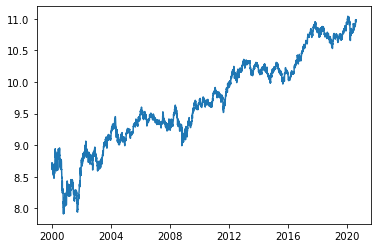

In [74]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3: 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [75]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [76]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

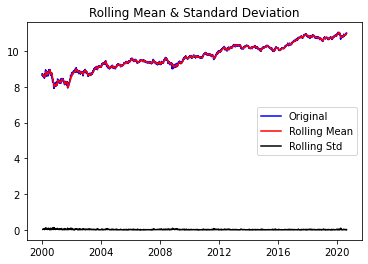

Results of Dickey-Fuller Test:
Test Statistic                   -0.681771
p-value                           0.851415
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [77]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

p-value 가 상당히 높기 때문에, 안정적인 시계열 데이터라고 할 수 없는 상태이다.

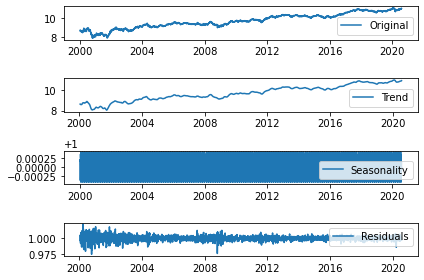

In [78]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [79]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728530e+01
p-value                        5.748585e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


### residual 데이터의 p-value : 5.748585e-30
상당히 안정적이라고 이야기 할 수 있을 것 같다

# STEP 4 : 학습, 테스트 데이터셋 생성

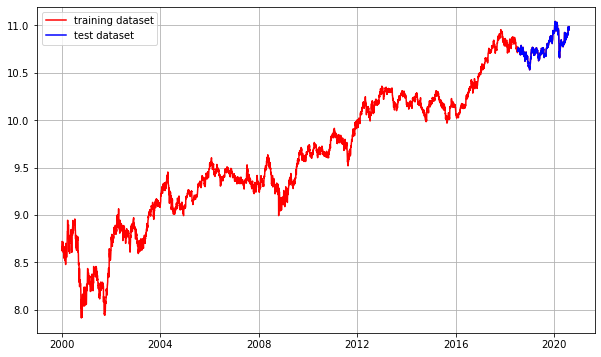

In [80]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5: 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

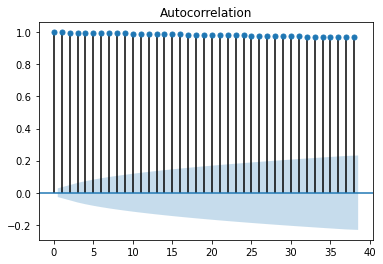

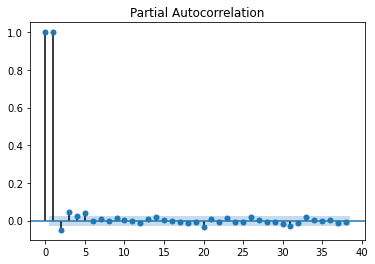

In [81]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

pacf 값의 분포를 보니 p는 1이 적당한 것 같고, q는 변경해보면서 확인해볼 필요가 있음

Results of Dickey-Fuller Test:
Test Statistic                  -39.817076
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


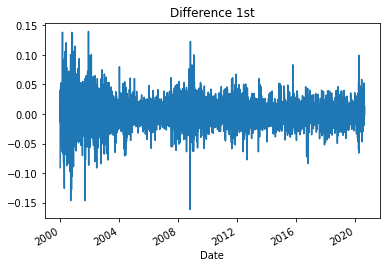

In [82]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.583520
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


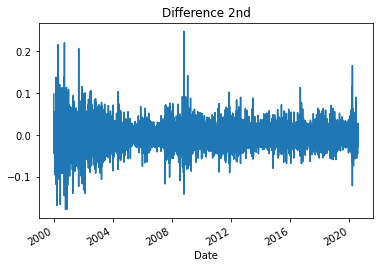

In [83]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d 값도 1,2 둘 다 해보는 것이 좋을듯!

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [84]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# p = 1, d =1, q = 0 으로해봄
model_110 = ARIMA(train_data, order=(1, 1, 0))  
fitted_m_110 = model_110.fit(disp=-1)  
print(fitted_m_110.summary())

ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        15:58:00   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Roots                            

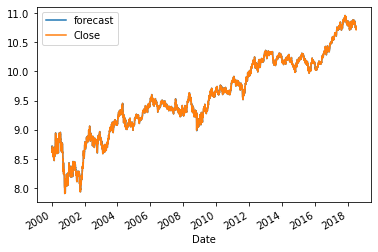

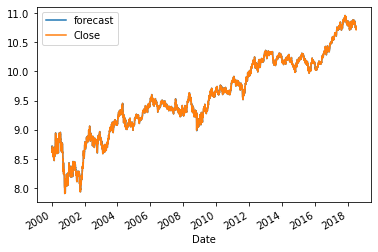

In [85]:
# 시각화
fitted_m_110.plot_predict()

In [86]:
# Build and Train  Model
# p = 1, d =1, q = 1 으로해봄
model_111 = ARIMA(train_data, order=(1, 1, 1))  
fitted_m_111 = model_111.fit(disp=-1)  
print(fitted_m_111.summary())

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 1)   Log Likelihood               10989.939
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21971.878
Time:        

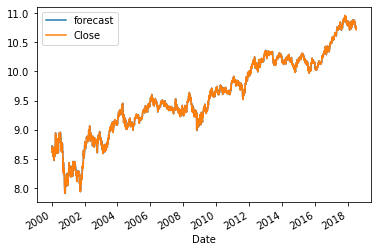

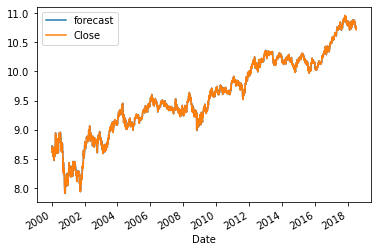

In [87]:
fitted_m_111.plot_predict()

In [88]:
# Build and Train  Model
# p = 1, d =2, q = 0 으로해봄
model_120 = ARIMA(train_data, order=(1, 2, 0))  
fitted_m_120 = model_120.fit(disp=-1)  
print(fitted_m_120.summary())

ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 4666
Model:                 ARIMA(1, 2, 0)   Log Likelihood                9969.376
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 13 Aug 2020   AIC                         -19932.751
Time:                        15:58:02   BIC                         -19913.407
Sample:                             2   HQIC                        -19925.948
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.192e-06      0.000      0.032      0.975      -0.001       0.001
ar.L1.D2.Close    -0.4369      0.013    -33.143      0.000      -0.463      -0.411
                                    Roots                        

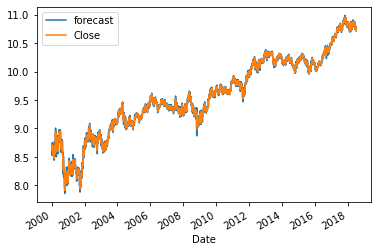

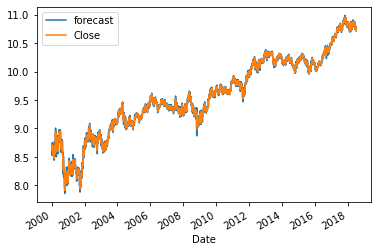

In [89]:
fitted_m_120.plot_predict()

---
### p = 1 d = 1 q = 0

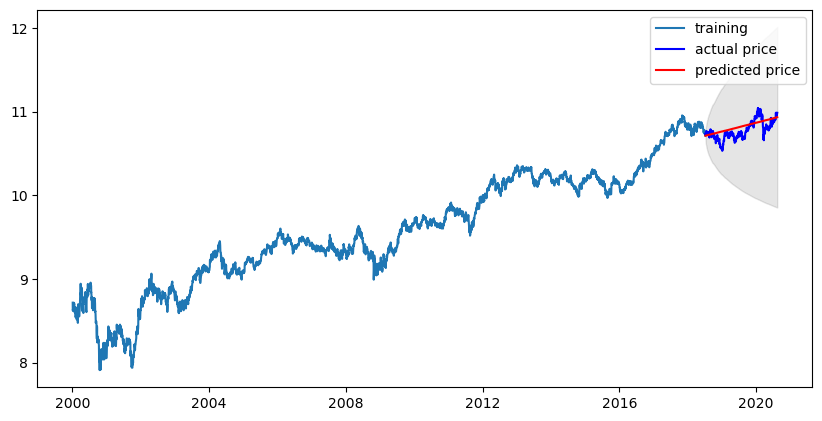

In [90]:
# p = 1 d =1 = 0 으로 했을 때 결과
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_110.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [91]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18521213.927795272
MAE:  3590.7680365630677
RMSE:  4303.627995981446
MAPE: 7.68%


### p = 1 , d =1 , q = 0 일 때 MAPE : 7.68%

---
### p = 1 d = 1 q = 1

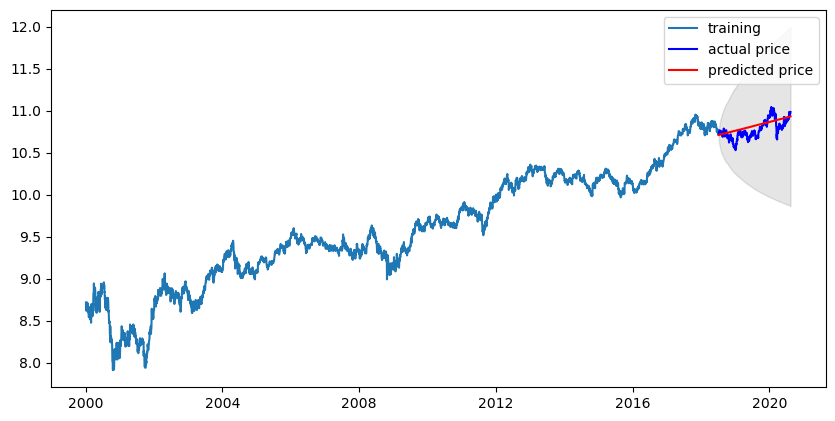

In [92]:
# p = 1 d =1 q = 1 으로 했을 때 결과
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_111.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [93]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18559989.449686237
MAE:  3595.524193027536
RMSE:  4308.130621242378
MAPE: 7.69%


### p = 1 , d =1 , q = 1 일 때 MAPE : 7.69%

---
### p = 1 d = 2 q = 0

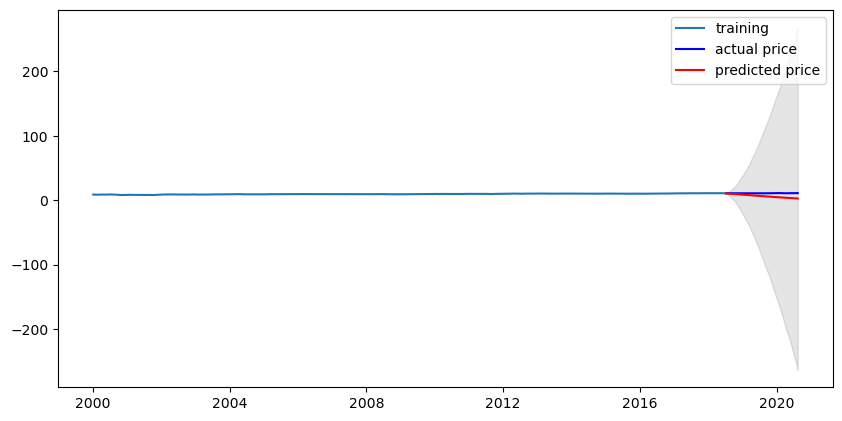

In [94]:
# p = 1 d =2 q = 0 으로 했을 때 결과
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_120.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [95]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2012828297.7854874
MAE:  43255.162798876045
RMSE:  44864.55502716468
MAPE: 89.10%


### p = 1 , d =2 , q = 0 일 때 MAPE : 89.1%

---
### p = 0, d = 1, q = 1

In [96]:
# Build and Train  Model
# p = 0, d =1, q = 1 으로해봄
model_011 = ARIMA(train_data, order=(1, 2, 0))  
fitted_m_011 = model_011.fit(disp=-1)  
print(fitted_m_011.summary())

ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 4666
Model:                 ARIMA(1, 2, 0)   Log Likelihood                9969.376
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 13 Aug 2020   AIC                         -19932.751
Time:                        15:58:03   BIC                         -19913.407
Sample:                             2   HQIC                        -19925.948
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.192e-06      0.000      0.032      0.975      -0.001       0.001
ar.L1.D2.Close    -0.4369      0.013    -33.143      0.000      -0.463      -0.411
                                    Roots                        

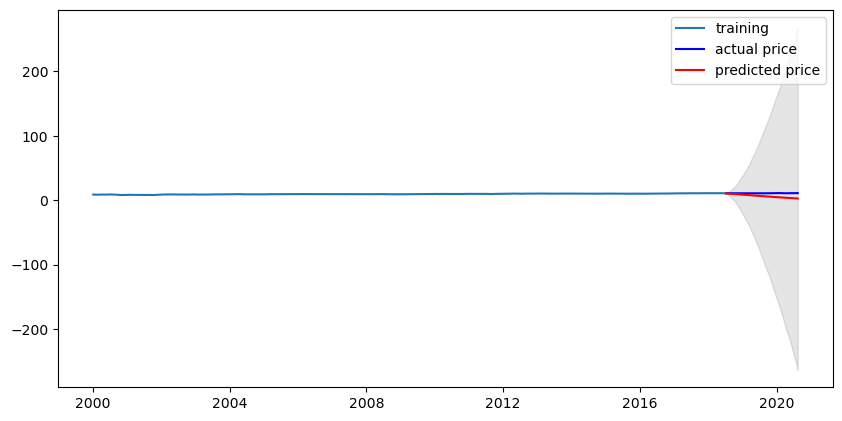

In [97]:
# p = 0 d =1 q = 1 으로 했을 때 결과
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_011.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [98]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2012828297.7854874
MAE:  43255.162798876045
RMSE:  44864.55502716468
MAPE: 89.10%


### p = 0, d  = 1, q = 1 MAPE : 89.1%

---
# 삼전 예측 프로젝트 결론 : MAPE 7.68%
p = 1, d = 1, q = 0 로 설정했을 때 MAPE 7.68%로 오차율이 가장 낮아진다

# STEP 7 : 다른 주식 종목 예측해 보기

관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

# 대상 종목 1 : 한국단자

In [99]:
dataset_filepath_2 = os.getenv('HOME')+'/aiffel/stock_prediction/data/025540.KS.csv' 
df_2 = pd.read_csv(dataset_filepath_2, index_col='Date', parse_dates=True)
print(type(df_2))
df_2.head()

<class 'pandas.core.frame.DataFrame'>


Open          High           Low         Close  \
Date                                                                 
2000-01-04  10843.900391  12164.000000  10843.900391  11645.400391   
2000-01-05  11645.400391  12635.500000  11645.400391  11739.700195   
2000-01-06  11786.799805  11881.099609  10843.900391  10938.200195   
2000-01-07  10561.000000  11126.799805  10278.099609  10561.000000   
2000-01-10  10655.299805  11315.299805  10372.400391  10843.900391   

               Adj Close   Volume  
Date                               
2000-01-04   9926.471680  12514.0  
2000-01-05  10006.850586  47617.0  
2000-01-06   9323.657227  33194.0  
2000-01-07   9002.133789  28634.0  
2000-01-10   9243.278320  59282.0

In [100]:
ts_2 = df_2['Close']
print(type(ts_2))

# 결측치 처리
# [[YOUR CODE]]
ts_2=ts_2.interpolate(method='time')
# ‘time’: Works on daily and higher resolution data to interpolate given length of interval.
ts_2[ts_2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

<class 'pandas.core.series.Series'>


Series([], Name: Close, dtype: float64)

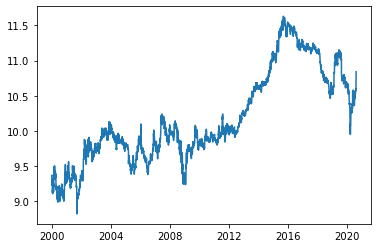

In [101]:
# 로그 변환
ts_2_log = np.log(ts_2)
plt.plot(ts_2_log)

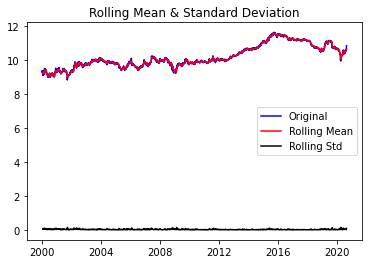

Results of Dickey-Fuller Test:
Test Statistic                   -1.556619
p-value                           0.505340
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [102]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_2_log)

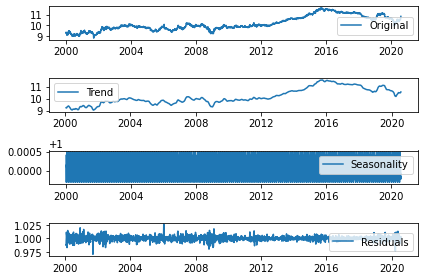

In [103]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_2 = seasonal_decompose(ts_2_log, model='multiplicative', period = 30) 

trend_2 = decomposition_2.trend
seasonal_2 = decomposition_2.seasonal
residual_2 = decomposition_2.resid

plt.subplot(411)
plt.plot(ts_2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [104]:
# Residual 안정성 확인
residual_2.dropna(inplace=True)
augmented_dickey_fuller_test(residual_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.823414e+01
p-value                        2.363381e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.124000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


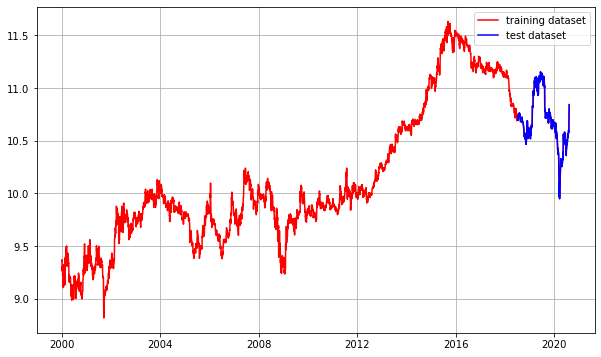

In [105]:
# 학습, 테스트 데이터 생성
train_data_2, test_data_2 = ts_2_log[:int(len(ts_2_log)*0.9)], ts_2_log[int(len(ts_2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_2, c='b', label='test dataset')
plt.legend()

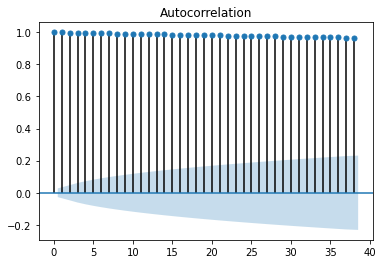

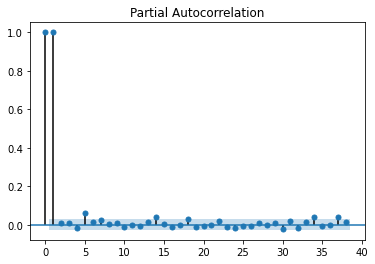

In [106]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -36.936991
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


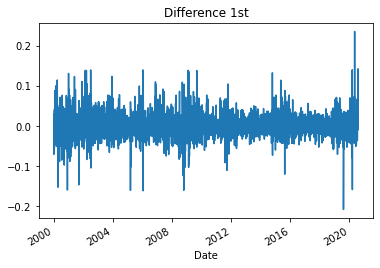

In [107]:
# 1차 차분 구하기
diff_1_2 = ts_2_log.diff(periods=1).iloc[1:]
diff_1_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_2)

Results of Dickey-Fuller Test:
Test Statistic                  -21.489046
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


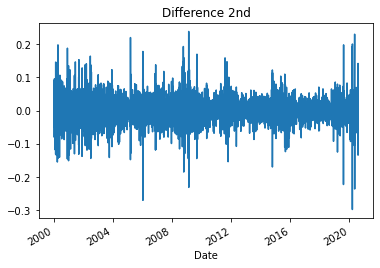

In [108]:
# 2차 차분 구하기
diff_2_2 = diff_1_2.diff(periods=1).iloc[1:]
diff_2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_2)

Results of Dickey-Fuller Test:
Test Statistic                  -28.723357
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5150.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -32.826389
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5149.000000
Critical Value (1%)              -3.431621
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -37.262610
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5148.000000
Critical Value (1%)              -3.431621
Critical Value (5%)              -2.862102
Critical Value (1

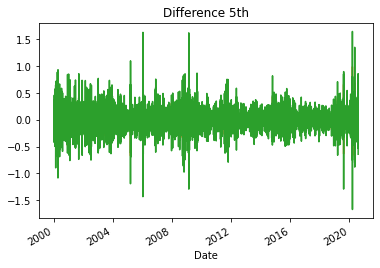

In [109]:
# 2차를 넘는 차분을 구해보자
# 3차 차분 구하기
diff_2_3 = diff_2_2.diff(periods=1).iloc[1:]
diff_2_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_2_3)
# 4차 차분 구하기
diff_2_4 = diff_2_3.diff(periods=1).iloc[1:]
diff_2_4.plot(title='Difference 4th')

augmented_dickey_fuller_test(diff_2_4)
# 5차 차분 구하기
diff_2_5 = diff_2_4.diff(periods=1).iloc[1:]
diff_2_5.plot(title='Difference 5th')

augmented_dickey_fuller_test(diff_2_5)

(p,d,q)
- (1,1,0)
- (1,2,0)
- (0,1,1)
- (0,1,2)
- (0,2,1)
- (0,2,2)

In [110]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# p = 1, d =1, q = 0 으로해봄
model_2_110 = ARIMA(train_data_2, order=(1, 1, 0))  
fitted_m_2_110 = model_2_110.fit(disp=-1)  
# print(fitted_m_2_110.summary())

# p = 1, d =2, q = 0 으로해봄
model_2_120 = ARIMA(train_data_2, order=(1, 2, 0))  
fitted_m_2_120 = model_2_120.fit(disp=-1) 

# p = 0, d =1, q = 1 으로해봄
model_2_011 = ARIMA(train_data_2, order=(0, 1, 1))  
fitted_m_2_011 = model_2_011.fit(disp=-1) 

# p = 0, d =1, q = 2 으로해봄
model_2_012 = ARIMA(train_data_2, order=(0, 1, 2))  
fitted_m_2_012 = model_2_012.fit(disp=-1) 

# p = 0, d =2, q = 1 으로해봄
model_2_021 = ARIMA(train_data_2, order=(0, 2, 1))  
fitted_m_2_021 = model_2_021.fit(disp=-1) 

# p = 0, d =2, q = 2 으로해봄
model_2_022 = ARIMA(train_data_2, order=(0, 2, 2))  
fitted_m_2_022 = model_2_022.fit(disp=-1) 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueW

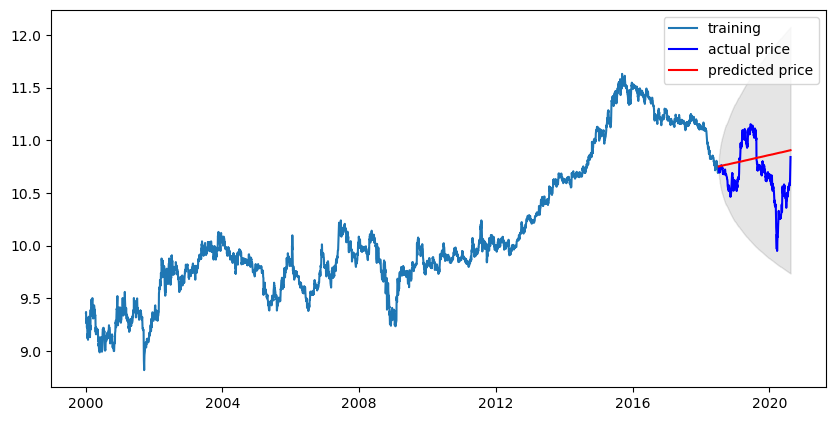

======================= 0 ===========================
MSE:  178738167.27398503
MAE:  11490.06420423547
RMSE:  13369.299430934481
MAPE: 29.17%


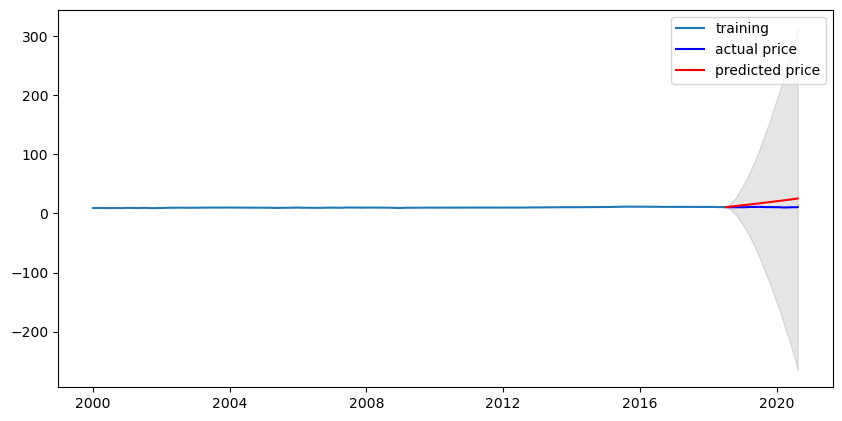

======================= 1 ===========================
MSE:  3.017355605712636e+20
MAE:  6231388638.507728
RMSE:  17370537141.12674
MAPE: 17016302.18%


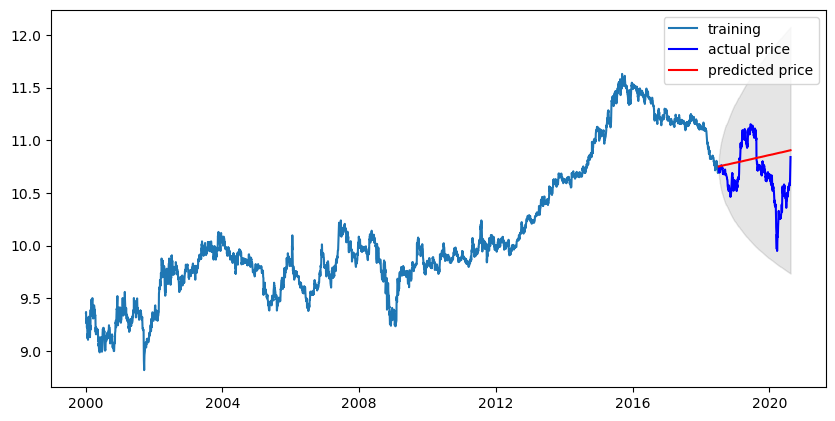

======================= 2 ===========================
MSE:  178745537.5562553
MAE:  11490.38873800961
RMSE:  13369.575070145473
MAPE: 29.17%


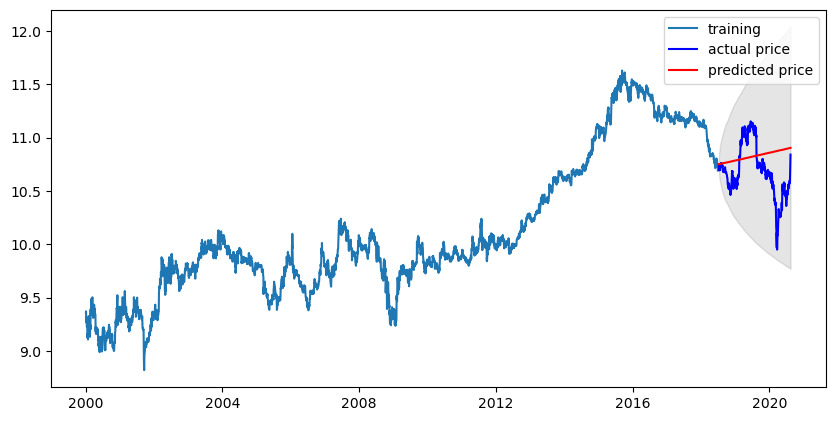

======================= 3 ===========================
MSE:  177998647.37482294
MAE:  11456.062200089496
RMSE:  13341.613372258355
MAPE: 29.06%


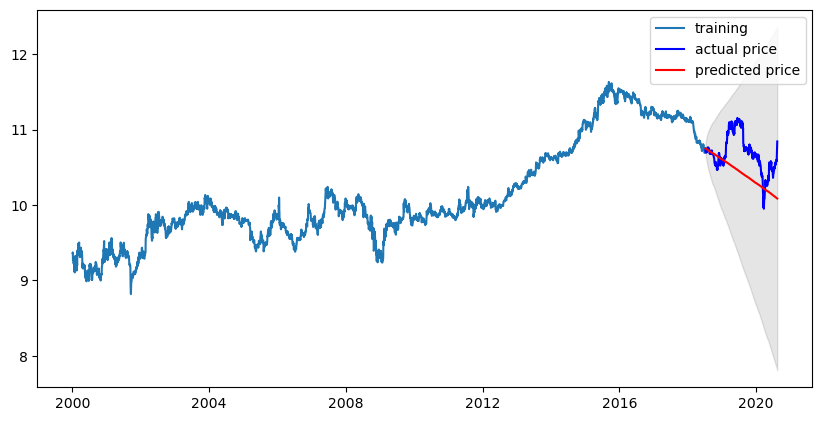

======================= 4 ===========================
MSE:  242626721.75230905
MAE:  12048.269012220979
RMSE:  15576.47976123967
MAPE: 24.21%


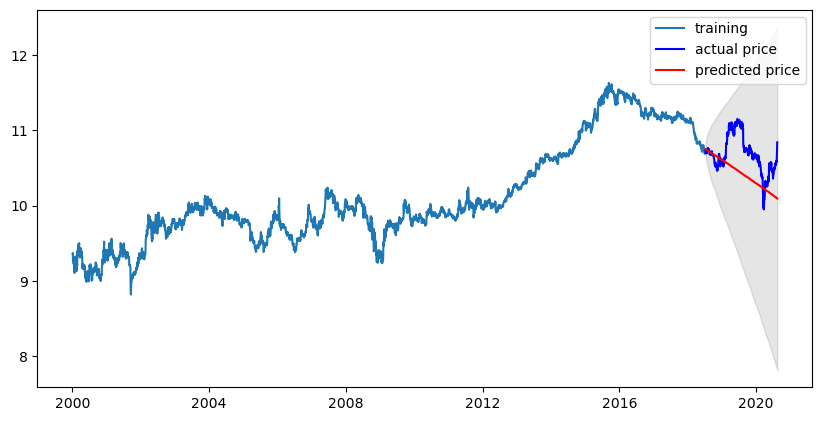

======================= 5 ===========================
MSE:  238939203.6185366
MAE:  11936.639142128006
RMSE:  15457.658413179422
MAPE: 23.96%


In [111]:
fitted_m_list = [fitted_m_2_110,
fitted_m_2_120,
fitted_m_2_011,
fitted_m_2_012,
fitted_m_2_021,
fitted_m_2_022]

for idx,el in enumerate(fitted_m_list):
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = el.forecast(len(test_data_2), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data_2.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data_2.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data_2.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data_2, label='training')
    plt.plot(test_data_2, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    print ('=======================',idx,'===========================')
    mse = mean_squared_error(np.exp(test_data_2), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data_2), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data_2), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_2))/np.abs(np.exp(test_data_2)))
    print('MAPE: {:.2f}%'.format(mape*100))

# 한국단자 결론 , MAPE : 23.96%

AR 모델의 시차를 결정하는 p값
MA 모델의 시차를 결정하는 q값

### p=1, d=1, q=0 으로 놓았을 때
오차율은 29.17% 이고, 상승 추세로 예측했다.

### p=0 , d=1, q=1,2 으로 놓았을 때
오차율은 29%대이고, 상승 추세로 예측했다.

### p=0 , d=2, q=1,2 으로 놓았을 때
오차율은 24% 가량으로 가장 낮고, 하락 추세로 예측했다.

### 생각
p 값을 올리면 AR 모델의 시차가 늘어나는 것이기 때문에 MA 모델의 힘이 더 작용하고
q 값을 올리면 MA 모델의 시차가 늘어나는 것이기 때문에 AR 모델의 힘이 더 작용하는 것으로 생각된다.

즉, p = 0, d = 2, q = 1,2 로 하면, p 대비 q 값이 크기 때문에, AR 모델의 힘이 더 작용하여 2012~2016년에 횡보 시기의 주가로 돌아가려는 성질을 보였다고 생각한다.

# STEP 7 : 다른 주식 종목 예측해 보기

관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

# 대상 종목 2 : SK 하이닉스

In [112]:
dataset_filepath_3 = os.getenv('HOME')+'/aiffel/stock_prediction/data/000660.KS.csv' 
df_3 = pd.read_csv(dataset_filepath_3, index_col='Date', parse_dates=True)
print(type(df_3))
df_3.head()

<class 'pandas.core.frame.DataFrame'>


Open      High       Low     Close      Adj Close    Volume
Date                                                                       
2000-01-04  518699.0  555449.0  508200.0  540749.0  295467.781250  441710.0
2000-01-05  507150.0  523949.0  477750.0  485100.0  265060.875000  353062.0
2000-01-06  493500.0  499800.0  454650.0  459900.0  251291.468750  310910.0
2000-01-07  445200.0  470400.0  436800.0  455700.0  248996.625000  499629.0
2000-01-10  462000.0  468300.0  451500.0  451500.0  246701.703125  382933.0

In [113]:
ts_3 = df_3['Close']
print(type(ts_3))

# 결측치 처리
# [[YOUR CODE]]
ts_3=ts_3.interpolate(method='time')
# ‘time’: Works on daily and higher resolution data to interpolate given length of interval.
ts_3[ts_3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

<class 'pandas.core.series.Series'>


Series([], Name: Close, dtype: float64)

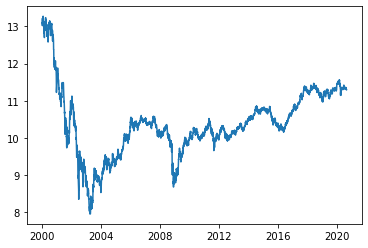

In [114]:
# 로그 변환
ts_3_log = np.log(ts_3)
plt.plot(ts_3_log)

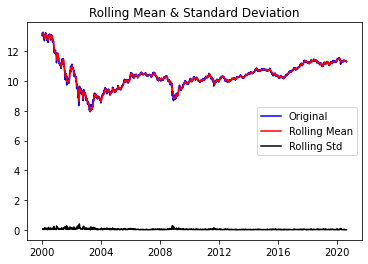

Results of Dickey-Fuller Test:
Test Statistic                   -2.963197
p-value                           0.038477
#Lags Used                        9.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [115]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_3_log)

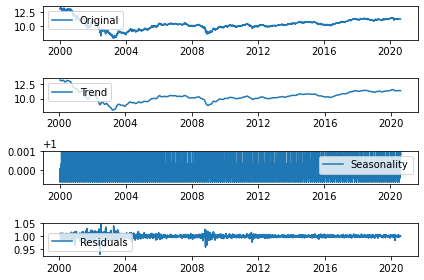

In [116]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_3 = seasonal_decompose(ts_3_log, model='multiplicative', period = 30) 

trend_3 = decomposition_3.trend
seasonal_3 = decomposition_3.seasonal
residual_3 = decomposition_3.resid

plt.subplot(411)
plt.plot(ts_3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [117]:
# Residual 안정성 확인
residual_3.dropna(inplace=True)
augmented_dickey_fuller_test(residual_3)

Results of Dickey-Fuller Test:
Test Statistic                -1.731706e+01
p-value                        5.510111e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.124000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


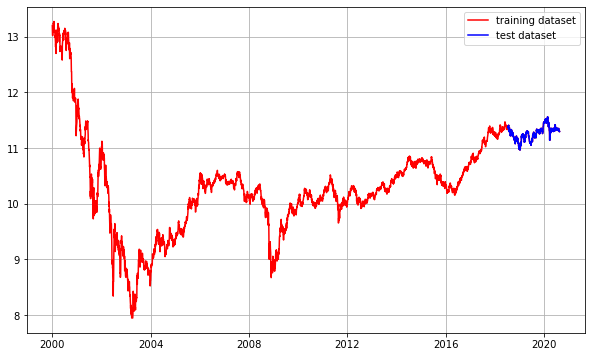

In [118]:
# 학습, 테스트 데이터 생성
train_data_3, test_data_3 = ts_3_log[:int(len(ts_3_log)*0.9)], ts_3_log[int(len(ts_3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_3, c='b', label='test dataset')
plt.legend()

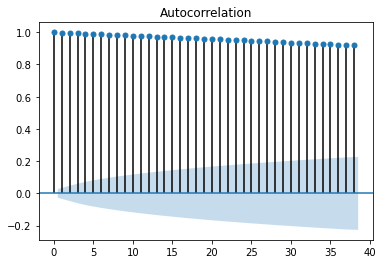

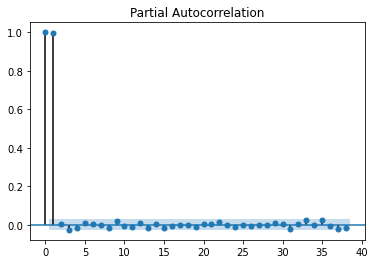

In [119]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_3_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_3_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.491136
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


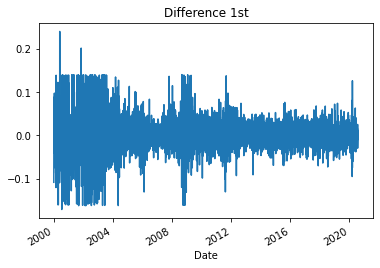

In [120]:
# 1차 차분 구하기
diff_1_3 = ts_3_log.diff(periods=1).iloc[1:]
diff_1_3.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_3)

Results of Dickey-Fuller Test:
Test Statistic                  -21.296079
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


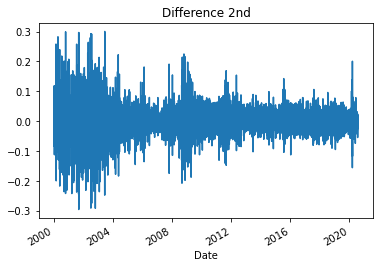

In [121]:
# 2차 차분 구하기
diff_2_3 = diff_1_3.diff(periods=1).iloc[1:]
diff_2_3.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_3)

In [122]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# p = 1, d =1, q = 0 으로해봄
model_3_110 = ARIMA(train_data_3, order=(1, 1, 0))  
fitted_m_3_110 = model_3_110.fit(disp=-1)  
# print(fitted_m_2_110.summary())

# p = 1, d =2, q = 0 으로해봄
model_3_120 = ARIMA(train_data_3, order=(1, 2, 0))  
fitted_m_3_120 = model_3_120.fit(disp=-1) 

# p = 0, d =1, q = 1 으로해봄
model_3_011 = ARIMA(train_data_3, order=(0, 1, 1))  
fitted_m_3_011 = model_3_011.fit(disp=-1) 

# p = 0, d =1, q = 2 으로해봄
model_3_012 = ARIMA(train_data_3, order=(0, 1, 2))  
fitted_m_3_012 = model_3_012.fit(disp=-1) 

# p = 0, d =2, q = 1 으로해봄
model_3_021 = ARIMA(train_data_3, order=(0, 2, 1))  
fitted_m_3_021 = model_3_021.fit(disp=-1) 

# p = 0, d =2, q = 2 으로해봄
model_3_022 = ARIMA(train_data_3, order=(0, 2, 2))  
fitted_m_3_022 = model_3_022.fit(disp=-1) 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueW

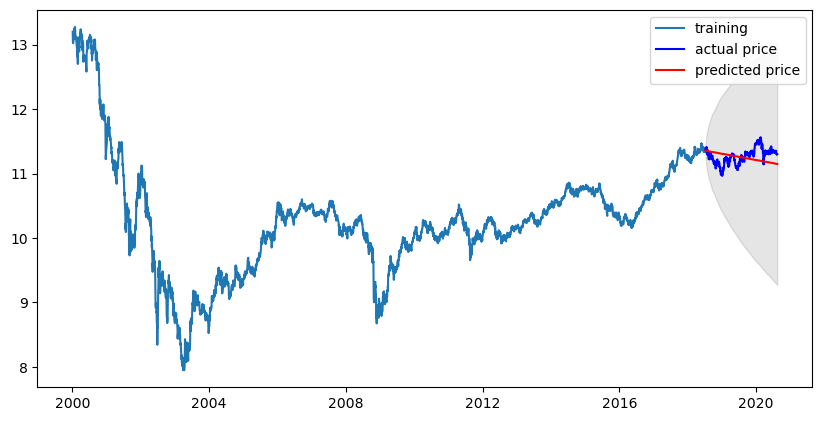

======================= 0 ===========================
MSE:  156497538.99091557
MAE:  10402.412652350697
RMSE:  12509.897641104646
MAPE: 13.18%


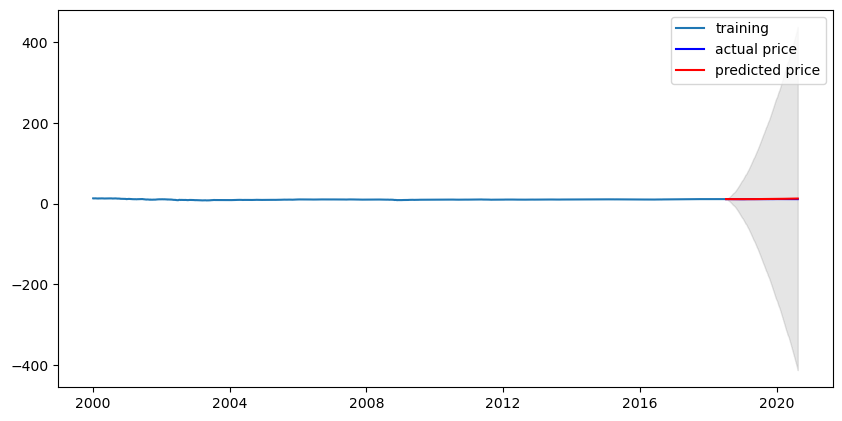

======================= 1 ===========================
MSE:  6954263364.130245
MAE:  50099.95317686492
RMSE:  83392.2260413418
MAPE: 60.58%


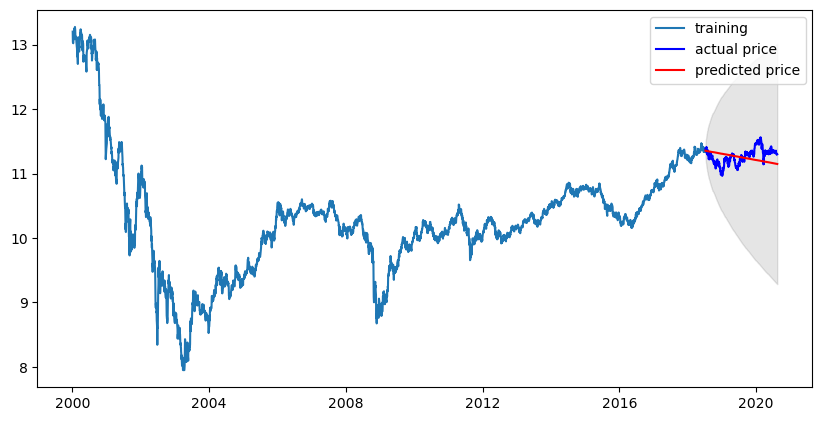

======================= 2 ===========================
MSE:  156447430.3483831
MAE:  10401.040106813723
RMSE:  12507.89472087062
MAPE: 13.18%


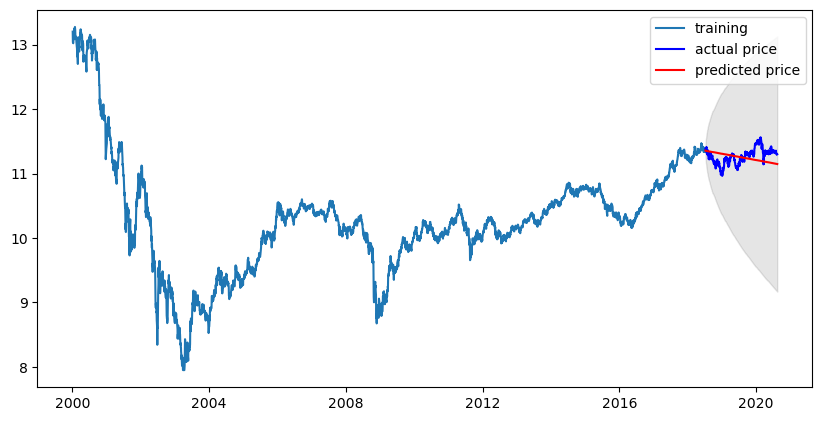

======================= 3 ===========================
MSE:  156986681.1410318
MAE:  10419.769870044158
RMSE:  12529.432594536427
MAPE: 13.20%


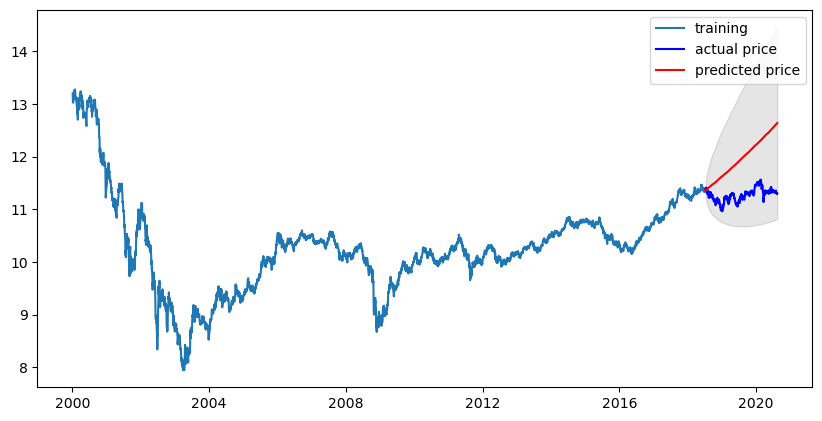

======================= 4 ===========================
MSE:  11570439281.724539
MAE:  90513.97948409583
RMSE:  107565.9764131974
MAPE: 112.40%


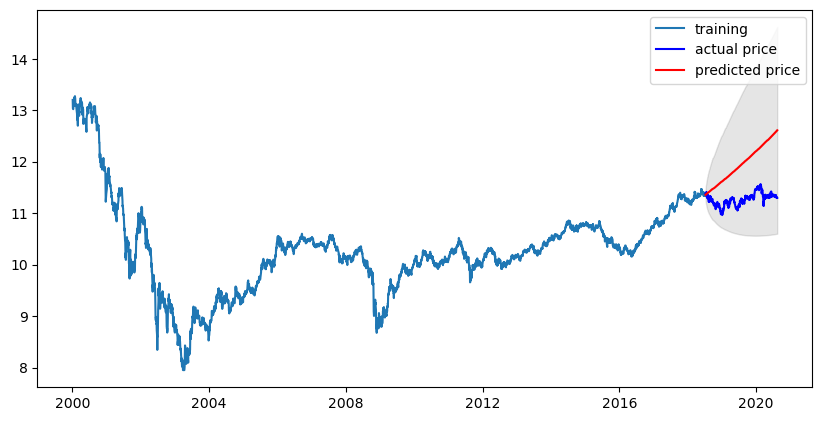

======================= 5 ===========================
MSE:  10827049760.757576
MAE:  87760.58589794894
RMSE:  104053.11028872503
MAPE: 109.05%


In [123]:
fitted_m_list_3 = [fitted_m_3_110,
fitted_m_3_120,
fitted_m_3_011,
fitted_m_3_012,
fitted_m_3_021,
fitted_m_3_022]

for idx,el in enumerate(fitted_m_list_3):
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = el.forecast(len(test_data_3), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data_3.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data_3.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data_3.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data_3, label='training')
    plt.plot(test_data_3, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    print ('=======================',idx,'===========================')
    mse = mean_squared_error(np.exp(test_data_3), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data_3), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data_3), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_3))/np.abs(np.exp(test_data_3)))
    print('MAPE: {:.2f}%'.format(mape*100))

In [132]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# p = 0, d =1, q = 4 으로해봄
model_3_014 = ARIMA(train_data_3, order=(0, 1, 4))  
fitted_m_3_014 = model_3_014.fit(disp=-1)  

# p = 0, d =1, q = 8 으로해봄
model_3_018 = ARIMA(train_data_3, order=(0, 1, 8))  
fitted_m_3_018 = model_3_018.fit(disp=-1)
 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueW

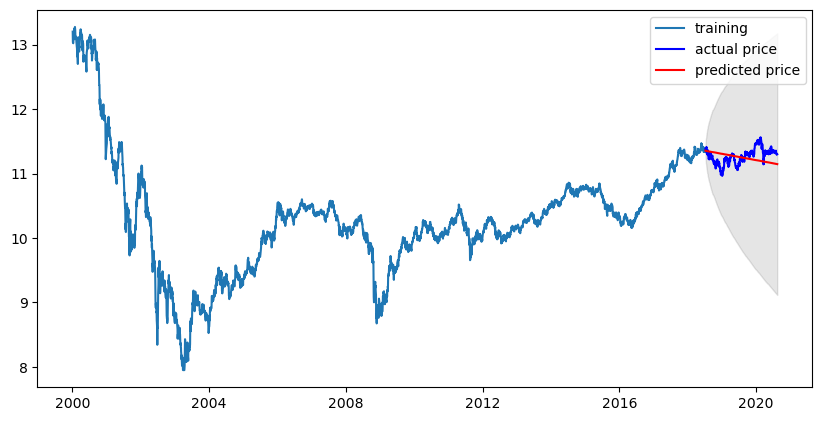

======================= 0 ===========================
MSE:  157453153.82812607
MAE:  10430.238420811678
RMSE:  12548.033863045082
MAPE: 13.21%


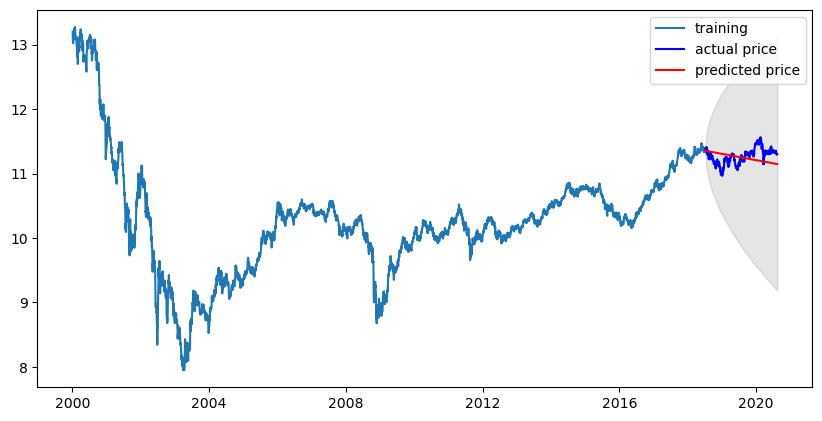

======================= 1 ===========================
MSE:  157273069.07293338
MAE:  10421.20466812643
RMSE:  12540.855994426112
MAPE: 13.19%


In [134]:
fitted_m_list_3_largeq = [fitted_m_3_014,fitted_m_3_018]

for idx,el in enumerate(fitted_m_list_3_largeq):
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = el.forecast(len(test_data_3), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data_3.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data_3.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data_3.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data_3, label='training')
    plt.plot(test_data_3, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    print ('=======================',idx,'===========================')
    mse = mean_squared_error(np.exp(test_data_3), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data_3), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data_3), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_3))/np.abs(np.exp(test_data_3)))
    print('MAPE: {:.2f}%'.format(mape*100))

# SK 하이닉스 결론 , MAPE : 13.18%
p = 1, d =1, q =0 일 때 MAPE 13.18% 로 가장 낮았다.